* Author: Wei
> Updated: Mar'2021

In [102]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from pprint import pprint
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.metrics import confusion_matrix,f1_score,classification_report, accuracy_score
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm

In [4]:
%%time
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

CPU times: user 2.57 s, sys: 1.67 s, total: 4.23 s
Wall time: 7.6 s


In [5]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  1538      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


## 1 preprocessing

In [18]:
batch_sentences = ["Price and policy fears drive Chinese investors into cloistered stocks.",
                    "Growth-oriented stocks have suffered globally in recent weeks from rising concerns over inflation.",
                    "Stocks advanced on Thursday and the Dow and S&P 500 each set record highs after President Joe Biden signed into law another expansive coronavirus relief package."]
encoded_inputs = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="tf")
# print(encoded_inputs)

In [19]:
pprint(encoded_inputs)

{'attention_mask': <tf.Tensor: shape=(3, 33), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>,
 'input_ids': <tf.Tensor: shape=(3, 33), dtype=int32, numpy=
array([[  101,  3976,  1998,  3343, 10069,  3298,  2822,  9387,  2046,
        18856, 10054, 14050, 15768,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [  101,  3930,  1011,  8048, 15768,  2031,  4265, 16452,  1999,
         3522,  3134,  2013,  4803,  5936,  2058, 14200,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    

In [20]:
for ids in encoded_inputs["input_ids"]:
    print(tokenizer.decode(ids))
    print(' ')

[CLS] price and policy fears drive chinese investors into cloistered stocks. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
 
[CLS] growth - oriented stocks have suffered globally in recent weeks from rising concerns over inflation. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
 
[CLS] stocks advanced on thursday and the dow and s & p 500 each set record highs after president joe biden signed into law another expansive coronavirus relief package. [SEP]
 


### 2 model fine-tuning

In [7]:
def read_imdb_split(split_dir):
    split_dir = Path(split_dir)
    texts = []
    labels = []
    for label_dir in ["pos", "neg"]:
        for text_file in (split_dir/label_dir).iterdir():
            texts.append(text_file.read_text())
            labels.append(0 if label_dir is "neg" else 1)

    return texts, labels

train_texts, train_labels = read_imdb_split('data/aclImdb/train')
test_texts, test_labels = read_imdb_split('data/aclImdb/test')

In [13]:
np.sum(train_labels)

12500

In [15]:
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.5, random_state=2021, shuffle=True)

In [16]:
print("Training data size is {}".format(len(train_texts)))
print(" data size is {}".format(len(val_texts)))
print("Testing data size is {}".format(len(test_texts)))

Training data size is 12500
 data size is 12500
Testing data size is 25000


In [104]:
def generate_bert_ids(tokenizer, texts, labels):
    bert_ids = tokenizer(texts, padding=True, truncation=True, return_tensors="tf", max_length=200)
    input_ids = np.asarray(bert_ids['input_ids'])
    attention_mask = np.asarray(bert_ids['attention_mask'])
    return input_ids, attention_mask, np.array(labels)

In [28]:
%%time
input_ids_tr, att_mask_tr, label_tr = generate_bert_ids(train_texts[:5000], train_labels[:5000])
input_ids_va, att_mask_va, label_va = generate_bert_ids(val_texts[:5000], val_labels[:5000])
input_ids_ts, att_mask_ts, label_ts = generate_bert_ids(test_texts, test_labels)

CPU times: user 1min 5s, sys: 1.81 s, total: 1min 7s
Wall time: 8.12 s


In [19]:
print("Training ids length is {}".format(len(input_ids_tr[0])))
print("Validation ids length is {}".format(len(input_ids_va[0])))
print("Testing ids length is {}".format(len(input_ids_ts[0])))

Training ids length is 200
Validation ids length is 200
Testing ids length is 200


In [20]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5,epsilon=1e-06)
model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

In [21]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto', restore_best_weights=True)]

In [22]:
%%time
history = model.fit([input_ids_tr,att_mask_tr],label_tr,
                       batch_size=64, 
                       epochs=3, 
                       validation_data=([input_ids_va,att_mask_va],label_va),
                       callbacks=callbacks)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
79/79 [==============================] - 1713s 22s/step - loss: 0.5573 - accuracy: 0.7007 - val_loss: 0.3026 - val_accuracy: 0.8756
Epoch 2/3
79/79 [==============================] - 2489s 32s/step - loss: 0.2537 - accuracy: 0.9009 - val_loss: 0.28

### 3 validation

In [29]:
%time tf_outputs = model.predict([input_ids_ts, att_mask_ts], batch_size=64)

CPU times: user 4h 49s, sys: 1h 1s, total: 5h 50s
Wall time: 35min 36s


In [30]:
preds = tf_outputs
pred_arr = tf.nn.softmax(preds[0], axis=-1)
pred_labels = tf.argmax(pred_arr, axis=1).numpy()

In [31]:
accuracy_score(label_ts,pred_labels)

0.87804

In [32]:
f1 = f1_score(label_ts,pred_labels)
print('F1 score',f1)
print('Classification Report')
print(classification_report(label_ts,pred_labels,
#                             target_names=target_names
                           ))

F1 score 0.8745319122669849
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.91      0.88     12500
           1       0.90      0.85      0.87     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [33]:
print(confusion_matrix(label_ts,pred_labels))

[[11325  1175]
 [ 1874 10626]]


## 4 re-structuring

In [34]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


### 4.1 raw-keras

In [64]:
from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.preprocessing import sequence, text
import matplotlib.pyplot as plt

In [53]:
# using keras tokenizer here
token = text.Tokenizer(num_words=20000) # or use None)
max_len = 1500

token.fit_on_texts(list(train_texts) + list(val_texts) + list(test_texts))
xtrain_seq = token.texts_to_sequences(train_texts)
xvalid_seq = token.texts_to_sequences(val_texts)
xtest_seq = token.texts_to_sequences(test_texts)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

In [54]:
print("Keras wordvector length is {}".format(len(word_index)))

Keras wordvector length is 124252


In [77]:
# create model structure
model_keras = tf.keras.Sequential([
    layers.Embedding(len(word_index) + 1, 32),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])
model_keras.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          3976096   
_________________________________________________________________
dropout_32 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
global_average_pooling1d_6 ( (None, 32)                0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 3,976,129
Trainable params: 3,976,129
Non-trainable params: 0
_________________________________________________________________


In [82]:
model_keras.compile(loss=losses.BinaryCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
             metrics=tf.keras.metrics.BinaryAccuracy(threshold=0.5))

In [83]:
%%time
# fit the model
epochs = 100
history = model_keras.fit(xtrain_pad, np.array(train_labels),
                       batch_size=64, 
                       epochs=epochs, 
                       validation_data=(xvalid_pad,np.array(val_labels)),
                       callbacks=callbacks)

Epoch 1/100
196/196 [==============================] - 9s 45ms/step - loss: 0.6900 - binary_accuracy: 0.4978 - val_loss: 0.6861 - val_binary_accuracy: 0.5000
Epoch 2/100
196/196 [==============================] - 9s 44ms/step - loss: 0.6833 - binary_accuracy: 0.4951 - val_loss: 0.6754 - val_binary_accuracy: 0.5002
Epoch 3/100
196/196 [==============================] - 9s 45ms/step - loss: 0.6704 - binary_accuracy: 0.5009 - val_loss: 0.6579 - val_binary_accuracy: 0.5111
Epoch 4/100
196/196 [==============================] - 9s 45ms/step - loss: 0.6492 - binary_accuracy: 0.5200 - val_loss: 0.6341 - val_binary_accuracy: 0.5228
Epoch 5/100
196/196 [==============================] - 9s 45ms/step - loss: 0.6230 - binary_accuracy: 0.5440 - val_loss: 0.6070 - val_binary_accuracy: 0.5616
Epoch 6/100
196/196 [==============================] - 9s 45ms/step - loss: 0.5930 - binary_accuracy: 0.5817 - val_loss: 0.5803 - val_binary_accuracy: 0.6370
Epoch 7/100
196/196 [==============================]

In [84]:
# plot history training results
history_dict = history.history
# history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

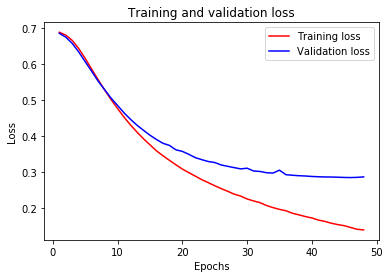

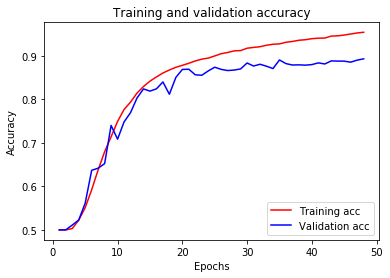

In [85]:
# plot on loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot on accuracy
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [86]:
preds = model_keras.predict_classes(xtest_pad)

In [87]:
accuracy_score(label_ts, preds)

0.87284

In [89]:
f1 = f1_score(label_ts,preds)
print('F1 score',f1)
print('Classification Report')
print(classification_report(label_ts,preds,
#                             target_names=target_names
                           ))

F1 score 0.8658140222025241
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     12500
           1       0.92      0.82      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.88      0.87      0.87     25000
weighted avg       0.88      0.87      0.87     25000



In [90]:
print(confusion_matrix(label_ts,preds))

[[11565   935]
 [ 2244 10256]]


### 4.2 self defined BERT

## 5 understand the tokenizer

### 5.1 basic usage

In [156]:
tokenizer.vocab_size

30522

In [160]:
sent = "He remains characteristically confident and optimistic."
tkens = tokenizer.tokenize(sent)
tkens

['he',
 'remains',
 'characteristic',
 '##ally',
 'confident',
 'and',
 'optimistic',
 '.']

In [161]:
tokenizer.convert_tokens_to_ids(tkens)

[2002, 3464, 8281, 3973, 9657, 1998, 21931, 1012]

In [162]:
tokenizer.convert_tokens_to_string(tkens)

'he remains characteristically confident and optimistic .'

### 5.2 BERT Tokenizer

In [163]:
from transformers import BertTokenizer

In [164]:
tz = BertTokenizer.from_pretrained("bert-base-uncased")

In [165]:
sent = "Let's learn deep learning!"

In [169]:
encoded = tz.encode_plus(
    text=sent,  # the sentence to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = 32,  # maximum length of a sentence
    pad_to_max_length=True,  # Add [PAD]s
    return_attention_mask = True,  # Generate the attention mask
    return_tensors = 'tf',  # ask the function to return PyTorch tensors
)

# Get the input IDs and attention mask in tensor format
input_ids = encoded['input_ids']
attn_mask = encoded['attention_mask']

In [175]:
[(k, v) for (k,v) in encoded.items()]

[('input_ids', <tf.Tensor: shape=(1, 32), dtype=int32, numpy=
  array([[ 101, 2292, 1005, 1055, 4553, 2784, 4083,  999,  102,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
        dtype=int32)>),
 ('token_type_ids', <tf.Tensor: shape=(1, 32), dtype=int32, numpy=
  array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>),
 ('attention_mask', <tf.Tensor: shape=(1, 32), dtype=int32, numpy=
  array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>)]

In [198]:
sent_list = ["i like skinning", "i don't know who i can turn to, it is really a disaster", "this is the third biggest city"]

In [203]:
encoded = tz(
    text=sent_list,  # the sentence to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = 32,  # maximum length of a sentence
    pad_to_max_length=True,  # Add [PAD]s
    return_attention_mask = True,  # Generate the attention mask
    return_tensors = 'tf',  # ask the function to return PyTorch tensors
)

# Get the input IDs and attention mask in tensor format
input_ids = encoded['input_ids']
attn_mask = encoded['attention_mask']

In [204]:
[(k, v) for (k,v) in encoded.items()]

[('input_ids', <tf.Tensor: shape=(3, 32), dtype=int32, numpy=
  array([[ 101, 1045, 2066, 3096, 5582,  102,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
         [ 101, 1045, 2123, 1005, 1056, 2113, 2040, 1045, 2064, 2735, 2000,
          1010, 2009, 2003, 2428, 1037, 7071,  102,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
         [ 101, 2023, 2003, 1996, 2353, 5221, 2103,  102,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
        dtype=int32)>),
 ('token_type_ids', <tf.Tensor: shape=(3, 32), dtype=int32, numpy=
  array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [201]:
_input1, _att1, _ = generate_bert_ids(tz, sent, 1)
print(_input1)
print(_att1)

[[ 101 2292 1005 1055 4553 2784 4083  999  102]]
[[1 1 1 1 1 1 1 1 1]]


In [202]:
_input2, _att2, _ = generate_bert_ids(tz, sent_list, [0,1])
print(_input2)
print(_att2)

[[ 101 1045 2066 3096 5582  102    0    0    0    0    0    0    0    0
     0    0    0    0]
 [ 101 1045 2123 1005 1056 2113 2040 1045 2064 2735 2000 1010 2009 2003
  2428 1037 7071  102]
 [ 101 2023 2003 1996 2353 5221 2103  102    0    0    0    0    0    0
     0    0    0    0]]
[[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]]


* usage of tokenizer
    * for single sentence, you can use tz.encode_plut
    * for texts list or dataframe, it is recommend to define a function with tokenizer